# Togetherflow
**Emergent agent motion dynamics in immersive rooms**

In this notebook, we implement Togetherflow, a computational cognitive model that characterizes the motion pattern of human agents in immersive rooms.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from numba import njit
from functools import partial

np.set_printoptions(suppress=True)

In [4]:
import tensorflow as tf
import bayesflow as bf
from bayesflow.simulation import Prior, Simulator, GenerativeModel

In [270]:
from initializations import initialize_agents, initialize_beacons
from influences import external_influence, internal_influence
from priors import complete_pooling_prior_fun
from diagnostics import plot_external_influence

## Initializations

In [6]:
agent_positions, agent_rotations = initialize_agents()
beacon_positions = initialize_beacons()

In [7]:
print(agent_positions.shape, agent_rotations.shape, beacon_positions.shape)

(12, 2) (12, 1) (10, 2)


## Influences

In [8]:
num_agents = len(agent_positions)
e = np.empty((num_agents, 2))
for i in range(num_agents):
    e[i] = external_influence(agent_positions[i], beacon_positions[0])

e

array([[-0.71673417, -0.69734651],
       [-0.87773985, -0.47913751],
       [-0.99808401,  0.06187323],
       [-0.99987185,  0.0160074 ],
       [-0.99209172, -0.12551516],
       [-0.75338775, -0.65757656],
       [-0.99886364, -0.04765938],
       [-0.99960363, -0.02815328],
       [-0.99588495, -0.09062664],
       [-0.88358957, -0.46826223],
       [-0.86887747, -0.49502715],
       [-0.52389932, -0.85178018]])

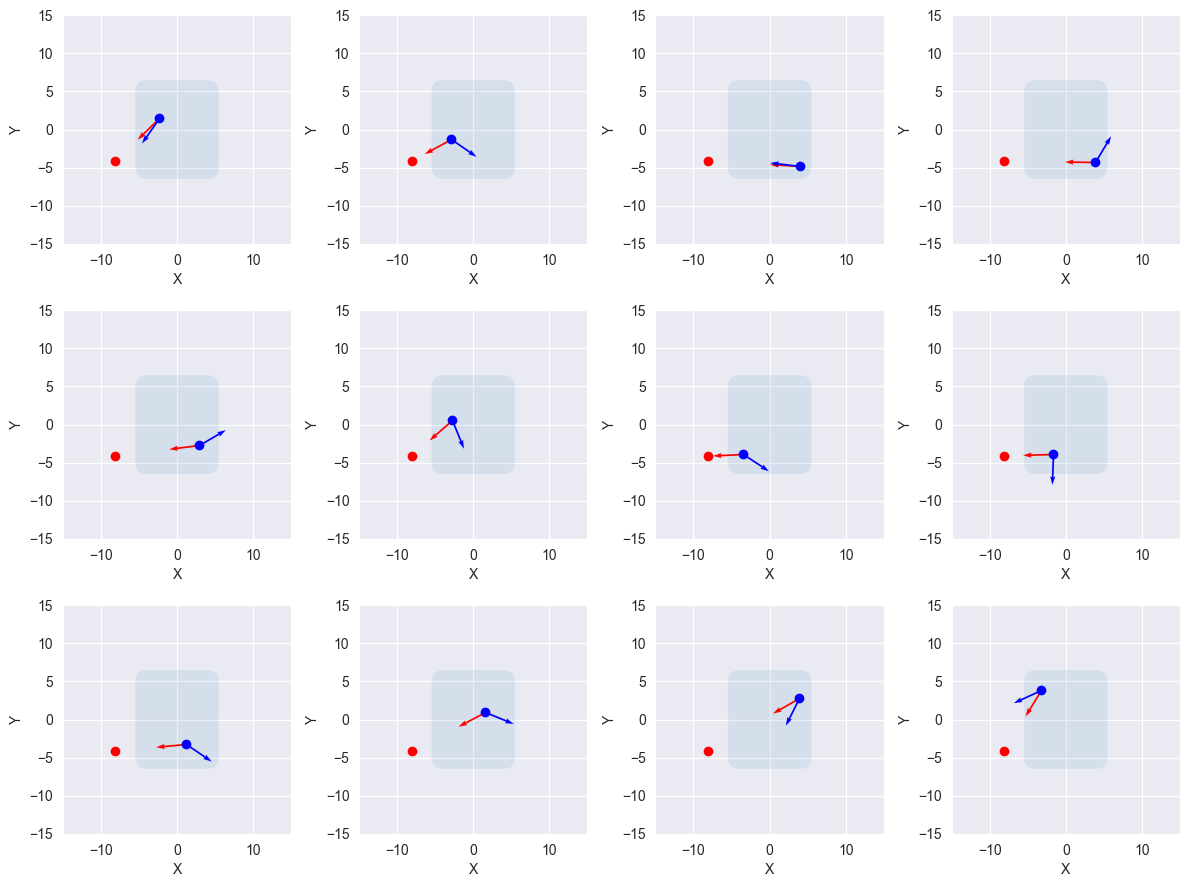

In [272]:
f = plot_external_influence(
    num_agents, agent_positions, agent_rotations, beacon_positions, e
)

In [247]:
@njit
def rotation_ddm(
    agent_rotation, 
    beacon_influence, 
    dt=0.1, 
    drift_rate=0.1, 
    noise_amplitude = 0.001,
    timesteps=100
):
    beacon_orientation = np.arctan2(beacon_influence[1], beacon_influence[0])
    rotations = np.zeros((timesteps, 1), dtype=np.float32)
    rotations[0] = (agent_rotation + np.pi) % (2 * np.pi) - np.pi
    steady_state = False
    
    for t in range(1, timesteps):
        rotation_diff = (beacon_orientation - rotations[t-1] + np.pi) % (2 * np.pi) - np.pi
        rotation_drift = drift_rate * rotation_diff
        
        if steady_state is True:
            rotations[t] = beacon_orientation + (np.random.random() - 0.5) * noise_amplitude
        else:
            rotations[t] = rotations[t-1] + rotation_drift * dt + noise_amplitude * np.random.randn()
        
            if np.abs(rotation_diff) < noise_amplitude:
                steady_state = True
    
    return rotations